# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Finding-HIF-1-direct-target-candidates" data-toc-modified-id="Finding-HIF-1-direct-target-candidates-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Finding HIF-1 direct target candidates</a></div><div class="lev1 toc-item"><a href="#egl-9-dependent,-non-hif-1-dependent,-genes" data-toc-modified-id="egl-9-dependent,-non-hif-1-dependent,-genes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span><em>egl-9</em> dependent, non-<em>hif-1</em>-dependent, genes</a></div><div class="lev1 toc-item"><a href="#vhl-1-dependent,-non-hif-1-dependent,-genes" data-toc-modified-id="vhl-1-dependent,-non-hif-1-dependent,-genes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><em>vhl-1</em> dependent, non-<em>hif-1</em>-dependent, genes</a></div>

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np

# morgan
import morgan as morgan
import tissue_enrichment_analysis as tea
import epistasis as epi
import genpy
import gvars


# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})


# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
q = 0.1
genvar = gvars.genvars()
tissue_df = tea.fetch_dictionary()
phenotype_df = pd.read_csv('../input/phenotype_ontology.csv')
go_df = pd.read_csv('../input/go_dictionary.csv')

In [3]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
# Specify which genotypes are double mutants 
# and of what single mutants:
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
# target_id is the column with isoform specific names
# b is the name of the column with the GLM regression coefficients
# tpm is the name of the column with the TPM numbers
# qval is the name of the column with the FDR corrected q-values
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# load all the beta values for each genotype:
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)

thomas.filter_data(0, 0.1)

In [4]:
frames = []
for key, df in thomas.beta.items():
    df['genotype'] = genvar.fancy_mapping[key]
    df['code'] = key
    frames += [df]
tidy_data = pd.concat(frames)
tidy_data = tidy_data[tidy_data.code != 'g']

# Finding HIF-1 direct target candidates

In [5]:
positive = tidy_data[tidy_data.b > 0]
negative = tidy_data[tidy_data.b < 0]

def collate(genes, df=tidy_data):
    return (df.target_id.isin(genes))

In [6]:
hif1_up = epi.find_overlap(['e', 'b', 'd', 'a'], positive)
hif1_down = epi.find_overlap(['c', 'f'], negative)

ind = (collate(hif1_up) & collate(hif1_down)) & (tidy_data.code == 'e')
print(len(tidy_data[ind].ens_gene.unique()))
print(tidy_data[ind].b.min())

tidy_data[ind].sort_values('qval')[['ext_gene', 'target_id','b', 'qval']]

3
3.31861867523


,ext_gene,target_id,b,qval
19626,R08E5.3,R08E5.3,4.577666,0.000000e+00
31611,nit-1,ZK1058.6,3.369282,4.598481e-32
19618,NaN,R08E5.1.1,3.318619,1.164188e-09


We didn't get too many genes, so let's make the conditions less restrictive

In [7]:
positive = tidy_data[tidy_data.b > 0]
hif1_up = epi.find_overlap(['e', 'b', 'd', 'a'], positive)
hif1minus_up = epi.find_overlap(['c', 'f'], positive)

def collate(genes, df=tidy_data):
    return (df.target_id.isin(genes))

ind = collate(hif1_up) & (~collate(hif1minus_up)) & (tidy_data.code == 'e')
print(len(tidy_data[ind].ens_gene.unique()))
hypoxia_direct_targets = tidy_data[ind].sort_values('qval')[['ext_gene', 'ens_gene', 'target_id', 'b', 'qval']]
hypoxia_direct_targets.to_csv('../output/medium_confidence_hypoxia_targets_candidates.csv', index=False)

196


# *egl-9* dependent, non-*hif-1*-dependent, genes

In [8]:
egl_pos = epi.find_overlap(['e', 'b', 'a', 'f'], positive)
egl_neg = epi.find_overlap(['e', 'b', 'a', 'f'], negative)
egl = list(set(egl_pos + egl_neg))

eglhif_pos = epi.find_overlap(['b', 'e', 'c', 'f'], positive)
eglhif_neg = epi.find_overlap(['b', 'e', 'c', 'f'], negative)
same_dir = list(set(eglhif_pos + eglhif_neg))

vhl_sig = tidy_data[(tidy_data.code == 'd') & (tidy_data.qval < q)].target_id

ind = ((tidy_data.target_id.isin(egl)) & (~tidy_data.target_id.isin(same_dir))) & (~tidy_data.target_id.isin(vhl_sig))
egl_regulated = tidy_data[ind & (tidy_data.code == 'b')]
egl_regulated.shape

(63, 17)

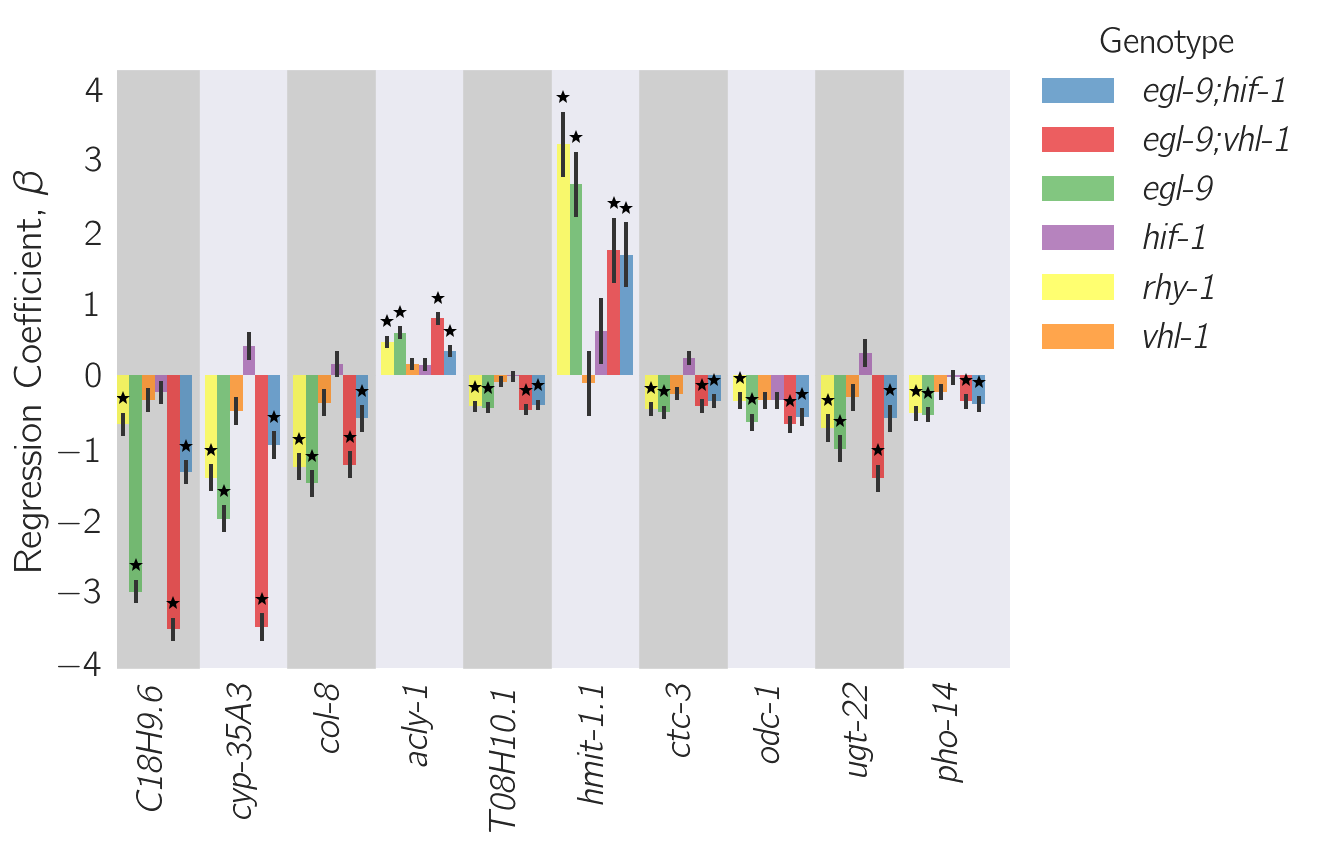

In [9]:
names = egl_regulated.sort_values('qval').target_id.unique()[0:10]

name_sort = {}
for i, name in enumerate(names):
    name_sort[name] = i+1

plot_df = tidy_data[tidy_data.target_id.isin(names)].copy()
plot_df['order'] = plot_df.target_id.map(name_sort)
plot_df.sort_values('order', inplace=True)
plot_df.reset_index(inplace=True)  

genpy.qPCR_plot(plot_df, genvar.plot_order, genvar.plot_color, clustering='genotype', plotting_group='target_id',
                rotation=90)

In [10]:
n = egl_regulated.ens_gene.unique().shape[0]
print('There appear to be {0} egl-specific genes'.format(n))
egl_regulated.to_csv('../output/egl_downstream.csv', index=False)

There appear to be 63 egl-specific genes


In [11]:
_ = tea.enrichment_analysis(egl_regulated.ens_gene.unique(), go_df)

Executing script

                                            Tissue  Expected  Observed  \
146               programmed cell death GO:0012501  3.150496        15   
105  structural constituent of ribosome GO:0003735  0.786250         6   
94                 nucleus organization GO:0006997  0.285909         3   

     Enrichment Fold Change       P value   Q value  
146                4.761155  1.833069e-07  0.000049  
105                7.631165  1.613482e-05  0.002178  
94                10.492852  1.988962e-04  0.017901  


In [16]:
go_df.head()

,wbid,regulation of cell shape GO:0008360,organelle fission GO:0048285,cell projection assembly GO:0030031,cellular aromatic compound metabolic process GO:0006725,membrane GO:0016020,cytoskeleton GO:0005856,"hydrolase activity, acting on glycosyl bonds GO:0016798",G-protein coupled receptor binding GO:0001664,carbohydrate binding GO:0030246,...,sodium ion transport GO:0006814,catabolic process GO:0009056,cognition GO:0050890,cell surface receptor signaling pathway involved in cell-cell signaling GO:1905114,perinuclear region of cytoplasm GO:0048471,rRNA metabolic process GO:0016072,carbohydrate metabolic process GO:0005975,neurotransmitter binding GO:0042165,negative regulation of proteolysis GO:0045861,digestive system development GO:0055123
0,WBGene00003678,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,WBGene00005194,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,WBGene00018097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,WBGene00001209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,WBGene00012717,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
melted_go = pd.melt(go_df, id_vars='wbid', value_name='expressed', var_name='term')
melted_go = melted_go[melted_go.expressed == 1]
egl_regulated[egl_regulated.ens_gene.isin(melted_go[(melted_go.wbid.isin(egl_regulated.ens_gene)) & (melted_go.term == 'programmed cell death GO:0012501')].wbid)].ext_gene

591       rps-0
2423      mes-6
4369      szy-4
10611     hsp-1
12341    rps-26
15238     ucr-1
17231     knl-2
17958     ani-2
21168    rps-19
21206     rmd-1
22765     wts-1
23530     chs-1
28105    vha-13
31228     gld-2
32439    rpl-35
Name: ext_gene, dtype: object

In [20]:
melted_go.head()

,wbid,term,expressed
18,WBGene00010366,regulation of cell shape GO:0008360,1.0
689,WBGene00015893,regulation of cell shape GO:0008360,1.0
702,WBGene00012307,regulation of cell shape GO:0008360,1.0
953,WBGene00022707,regulation of cell shape GO:0008360,1.0
1033,WBGene00019119,regulation of cell shape GO:0008360,1.0


In [12]:
_ = tea.enrichment_analysis(egl_regulated.ens_gene.unique(), phenotype_df)

Executing script

                                                Tissue  Expected  Observed  \
47   pachytene progression during oogenesis variant...  2.856723        12   
159  diplotene absent during oogenesis WBPhenotype:...  1.119668         6   
32     germ cell compartment small WBPhenotype:0001974  0.627851         4   
13                    nuclei small WBPhenotype:0001792  1.716127         7   
35   cell membrane organization biogenesis variant ...  3.390397        10   
100  germ cell compartment expansion variant WBPhen...  4.572850        12   

     Enrichment Fold Change   P value   Q value  
47                 4.200617  0.000008  0.001902  
159                5.358731  0.000141  0.017593  
32                 6.370935  0.000420  0.030103  
13                 4.078952  0.000361  0.030103  
35                 2.949507  0.000702  0.035077  
100                2.624184  0.000820  0.035077  


# *vhl-1* dependent, non-*hif-1*-dependent, genes


(44, 17)


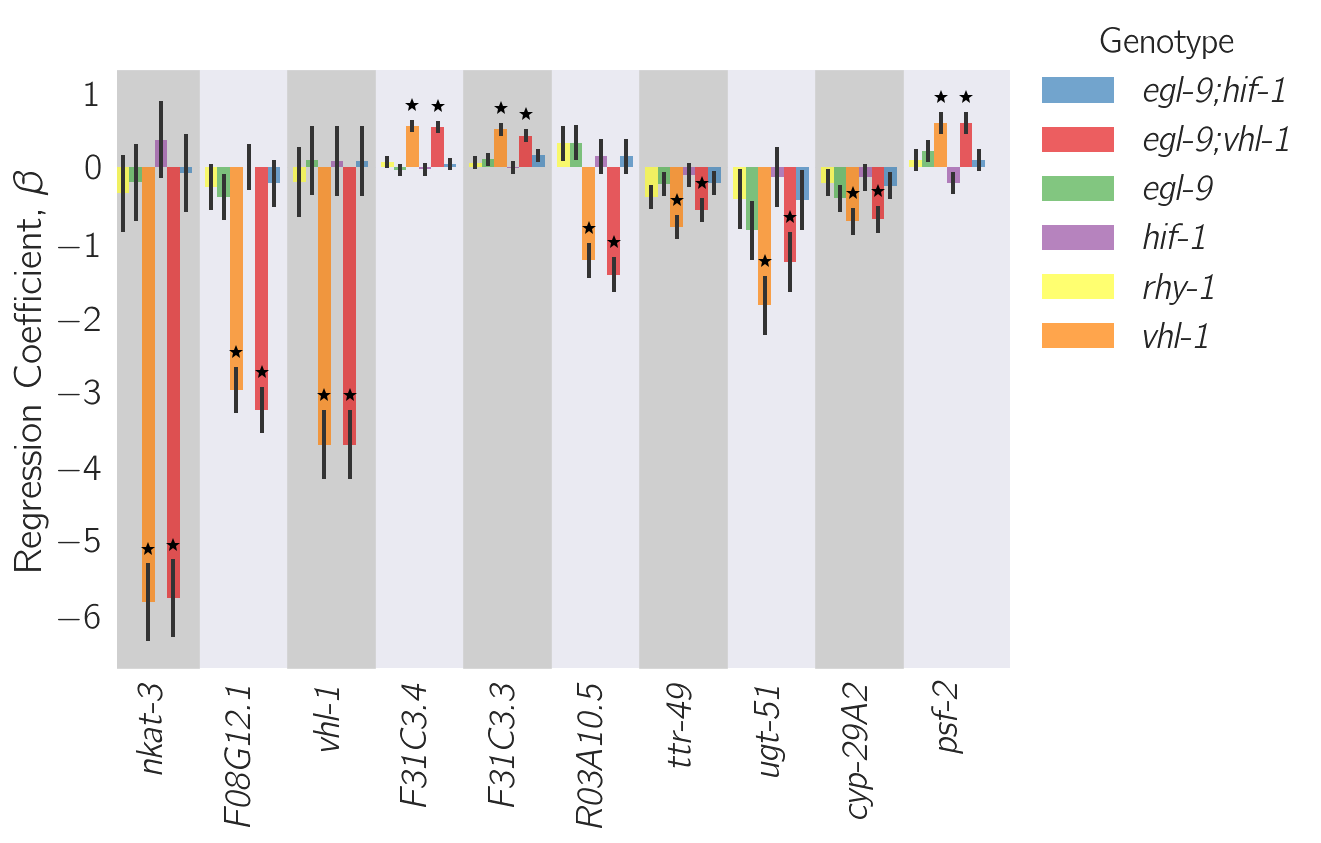

In [13]:
vhl_pos = epi.find_overlap(['d', 'a'], positive)
vhl_neg = epi.find_overlap(['d', 'a'], negative)
vhl = list(set(vhl_pos + vhl_neg))

others = tidy_data[(tidy_data.code.isin(['b', 'e', 'f', 'c']))  & (tidy_data.qval < 0.1)].target_id.unique()

ind = (tidy_data.target_id.isin(vhl)) & (~tidy_data.target_id.isin(others))

vhl_regulated = tidy_data[ind & (tidy_data.code == 'd')]

print(vhl_regulated.shape)

# begin plotting
names = vhl_regulated.sort_values('qval').target_id.unique()[0:10]
name_sort = {}
for i, name in enumerate(names):
    name_sort[name] = i+1

plot_df = tidy_data[tidy_data.target_id.isin(names)].copy()
plot_df['order'] = plot_df.target_id.map(name_sort)
plot_df.sort_values('order', inplace=True)
plot_df.reset_index(inplace=True)  

genpy.qPCR_plot(plot_df, genvar.plot_order, genvar.plot_color, clustering='genotype', plotting_group='target_id',
                rotation=90)
vhl_regulated[['ext_gene', 'ens_gene', 'target_id', 'b', 'qval']].to_csv('../output/vhl_1_regulated_genes.csv')